In [1]:
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from sklearn.dummy import DummyClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from numpy import array
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from pandas.plotting import lag_plot
from sklearn import metrics 
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf
from tqdm import tqdm
from random import choices

In [114]:
#Function for loading data!

def load_data():
    
    df = pickle.load(open('df_down_sampled.p','rb'))
    df = df.drop(['resp_1', 'resp_2','resp_3','resp_4'], axis = 1)
    df = df.sort_values(by = 'ts_id')
    df['y'] = 0
    mask = df.resp > 0  
    df.loc[mask,'y'] = 1    
    
    return df

In [115]:
#Function for performing pca-transformation!

def perform_pca_transformation(X_train, X_test, number_of_components):
    
    col_list = []

    for x in range(number_of_components):
        
        col_list.append('pca_feature_' + str(x))
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    pca = PCA(n_components = number_of_components)
    pca.fit(X_train_scaled)
    
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    X_train_pca = pd.DataFrame(data = X_train_pca, columns = col_list)
    X_test_pca = pd.DataFrame(data = X_test_pca, columns = col_list)
    
    return (X_train_pca, X_test_pca)

In [116]:
# Function for scaling only!
def perform_scaling(train, test):
    
    scaler = StandardScaler()
    scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    
    return (train, test)

In [117]:
#Function for splitting data into train/test set!

def train_test_split(test_share, data):
    
    #Split data into initial train/test
    
    train_share = 1 - test_share    
    train_size = int(len(data) * train_share)
    train_set = data[0:train_size]
    test_set = data[train_size:len(data)]    
    
    
    return (train_set, test_set)

In [118]:
def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df


In [119]:
def adding_lags(df, features, lags):
    """
    Input dataframe, features for lags and integer representing number of lags. Output dataframe with lagged variables
    Missing values imputed by mean level. Lag index is _lag#laginperiods. 
    """
    df
    for j in range(lags):
        for i in features:
            new_shift_col = i + f'_lag{j}'
            df[new_shift_col] = df[i].shift(j)
            df[new_shift_col] = df[i].shift(j)
    #df = df.fillna(df.mean())
    return df

In [120]:
#Load data!

df = load_data()

#Fill in missing values with mean for now!

df = df.fillna(df.mean())

df = reduce_memory_usage(df)

Memory usage of dataframe is 527.2220458984375 MB
Memory usage of dataframe after reduction 134.71298599243164 MB
Reduced by 74.44852941176471 % 


In [121]:
#Split into train/test!
train_set, test_set = train_test_split(test_share = 0.3, data = df)

In [ ]:
#train_set, test_set = perform_scaling(train_set, test_set)

In [122]:
X_train = train_set.drop(['date','weight','y','ts_id', 'resp'], axis = 1)
X_test = test_set.drop(['date','weight','y','ts_id', 'resp'], axis = 1)

y_train = train_set.y
y_test = test_set.y

In [123]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier()

Accuracy train: 55.03%
Accuracy test: 51.57%
The train roc is: 0.5787564273693525, the test roc is: 0.5262542550445711


Text(0, 0.5, 'Feature Importance Score')

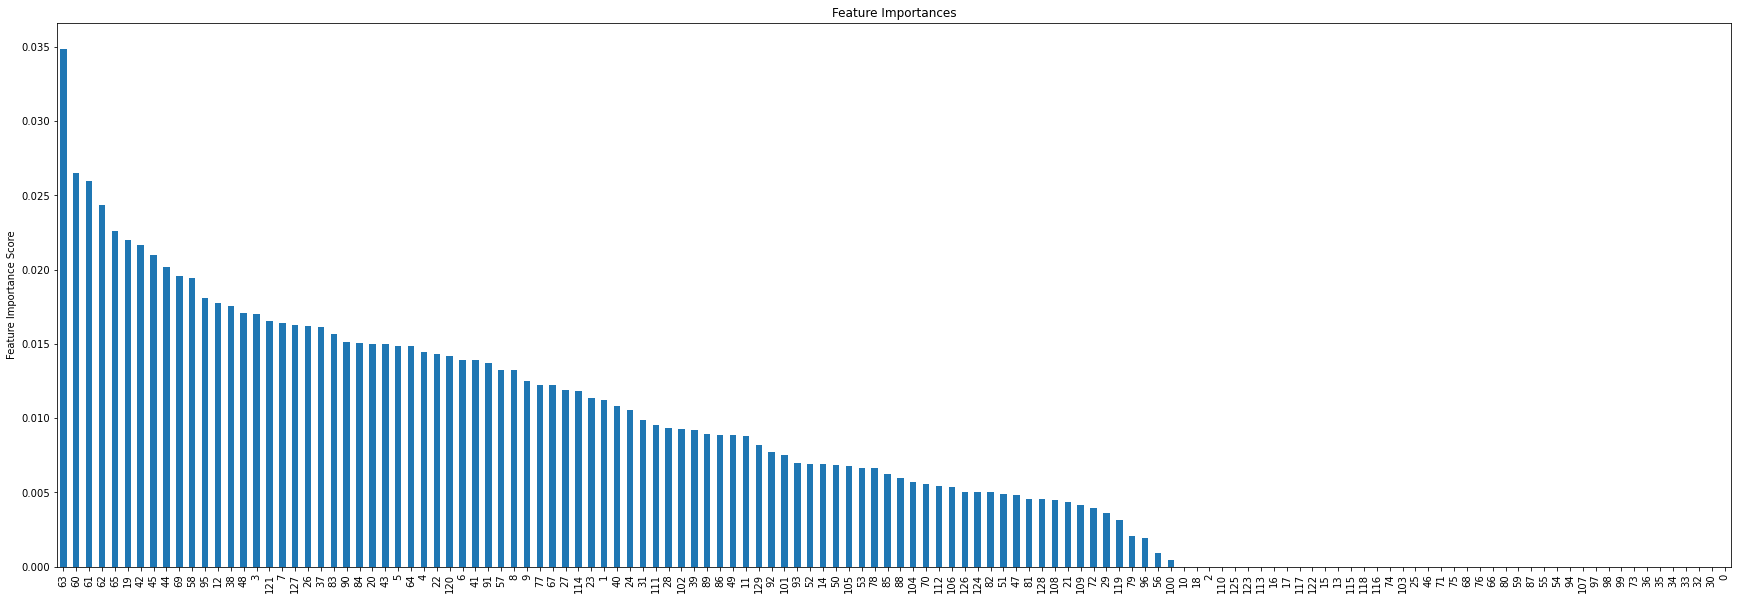

In [125]:
y_pred_train = model.predict_proba(X_train)[:,1]
y_pred_test = model.predict_proba(X_test)[:,1]
y_pred_train_a = model.predict(X_train)
y_pred_test_a = model.predict(X_test)
train_roc = roc_auc_score(y_train, y_pred_train)
test_roc = roc_auc_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test_a)
accuracy_train = accuracy_score(y_train, y_pred_train_a)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))
print("The train roc is: {}, the test roc is: {}".format(train_roc, test_roc))
plt.figure(figsize=(30,10))
feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [110]:
indx_test = X_test.iloc[:,feat_imp.nlargest(5).index].columns
indx_train = X_train.iloc[:,feat_imp.nlargest(5).index].columns
X_imp_test = adding_lags(X_test, indx_test,10)
X_imp_train = adding_lags(X_train, indx_train,10)

In [111]:
X_imp_test

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_63_lag8,feature_60_lag8,feature_61_lag8,feature_62_lag8,feature_65_lag8,feature_63_lag9,feature_60_lag9,feature_61_lag9,feature_62_lag9,feature_65_lag9
2238055,1,-0.048737,0.025284,0.860352,0.831543,0.740723,0.751465,-0.829102,-0.981445,-0.557129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2238056,-1,-1.417969,-2.039062,8.125000,5.878906,5.828125,4.023438,3.910156,3.240234,0.292725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2238057,-1,2.787109,1.277344,3.990234,2.580078,2.537109,1.577148,5.488281,4.210938,1.744141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2238058,1,6.523438,6.855469,-1.981445,-1.833008,-1.117188,-1.011719,-0.009804,-0.086304,6.343750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2238059,1,0.069458,-0.452148,-2.685547,-2.230469,-5.851562,-4.906250,2.033203,2.019531,1.415039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,1,-1.649414,-1.169922,-0.889160,-1.255859,-0.265381,-0.383545,0.526367,1.162109,-0.712891,...,0.174316,6.789062,6.277344,0.171143,-0.265381,0.461670,3.957031,3.671875,0.444580,1.925781
2390487,1,2.433594,5.285156,-0.337402,-0.494385,-0.442383,-0.739258,-0.064636,0.163208,-2.439453,...,0.168335,6.828125,6.281250,0.165771,-0.295166,0.174316,6.789062,6.277344,0.171143,-0.265381
2390488,1,-0.622559,-0.963867,0.532715,0.392334,0.977051,0.819824,0.140259,0.039215,-0.425537,...,6.175781,3.916016,3.640625,6.015625,1.933594,0.168335,6.828125,6.281250,0.165771,-0.295166
2390489,-1,-1.463867,-1.107422,-2.287109,-3.156250,-1.690430,-2.347656,-0.683594,-0.939453,-3.443359,...,1.136719,7.332031,6.722656,1.093750,-0.741699,6.175781,3.916016,3.640625,6.015625,1.933594


In [112]:
model = XGBClassifier()
model.fit(X_imp_train, y_train)

XGBClassifier()

Accuracy train: 55.03%
Accuracy test: 51.29%
The train roc is: 0.5792872724491982, the test roc is: 0.5218703379596978


Text(0, 0.5, 'Feature Importance Score')

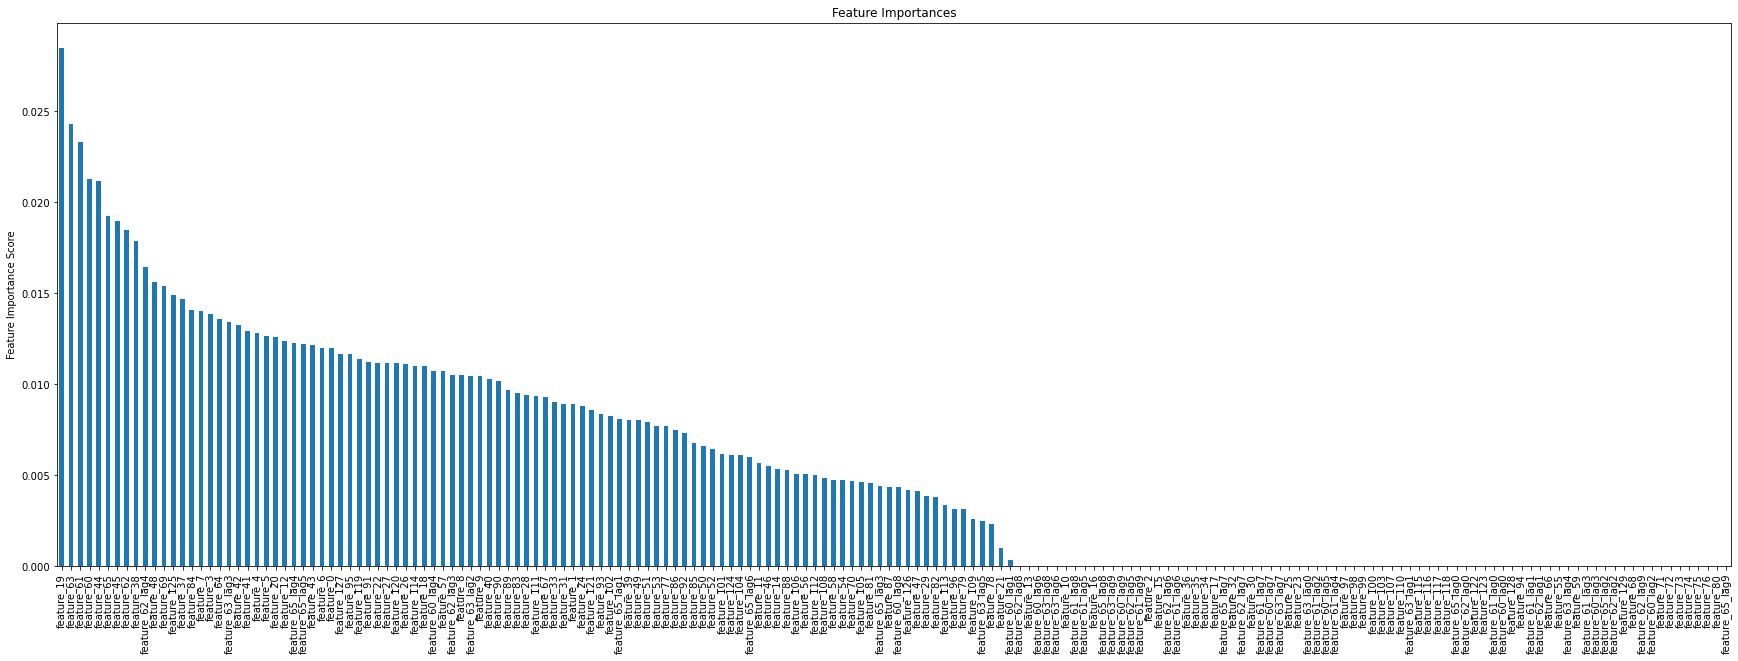

In [113]:
y_pred_train = model.predict_proba(X_imp_train)[:,1]
y_pred_test = model.predict_proba(X_imp_test)[:,1]
y_pred_train_a = model.predict(X_imp_train)
y_pred_test_a = model.predict(X_imp_test)
train_roc = roc_auc_score(y_train, y_pred_train)
test_roc = roc_auc_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test_a)
accuracy_train = accuracy_score(y_train, y_pred_train_a)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))
print("The train roc is: {}, the test roc is: {}".format(train_roc, test_roc))
plt.figure(figsize=(30,10))
feat_imp2 = pd.Series(model.feature_importances_).sort_values(ascending=False)
feat_imp2.index = X_imp_train.iloc[:,feat_imp2.index].columns
feat_imp2.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [158]:
blacklist = ['date','weight','y','ts_id', 'resp']
ix=[i for i in train_set.iloc[:,feat_imp.nlargest(20).index].columns if i not in blacklist]
train_pca, test_pca = perform_pca_transformation(train_set[ix], test_set[ix], 10)
train_pca_y=train_set.y.values
test_pca_y=test_set.y.values

In [141]:
model = XGBClassifier()
model.fit(train_pca, train_pca_y)

XGBClassifier()

The train roc is: 0.59309940322279, the test roc is: 0.5035373880488315


Text(0, 0.5, 'Feature Importance Score')

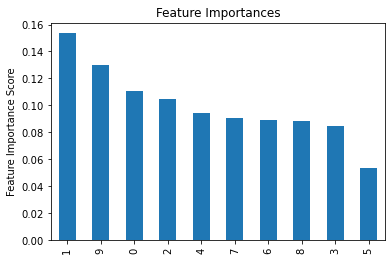

In [142]:
y_pred_train = model.predict_proba(train_pca)[:,1]
y_pred_test = model.predict_proba(test_pca)[:,1]
train_roc = roc_auc_score(y_train, y_pred_train)
test_roc = roc_auc_score(y_test, y_pred_test)
print("The train roc is: {}, the test roc is: {}".format(train_roc, test_roc))
feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [258]:
SEED = 1111

tf.random.set_seed(SEED)
np.random.seed(SEED)

train = pd.read_csv('data/train.csv', nrows= 100000)
#train = train.query('date > 85').reset_index(drop = True) 
train = train[train['weight'] != 0]

train.fillna(train.mean(),inplace=True)

train['action'] = ((train['resp'].values) > 0).astype(int)


features = [c for c in train.columns if "feature" in c]

f_mean = np.mean(train[features[1:]].values,axis=0)

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

X_train = train.loc[:, train.columns.str.contains('feature')]
#y_train = (train.loc[:, 'action'])

y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

In [259]:
X_train.shape, y_train.shape

((77759, 130), (77759, 5))

In [236]:
def create_mlp(
    num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)

    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )

    return model

In [237]:
batch_size = 5000
hidden_units = [150, 150, 150]
dropout_rates = [0.2, 0.2, 0.2, 0.2]
label_smoothing = 1e-2
learning_rate = 1e-3

In [254]:
X_imp_train.shape , y_train.values.reshape(-1,1).shape

((50811, 60), (50811, 1))

In [262]:
clf = create_mlp(
    len(X_imp_train.columns), 5, hidden_units, dropout_rates, label_smoothing, learning_rate
    )

clf.fit(X_train, y_train, epochs=20, batch_size=500)

Epoch 1/20


ValueError: in user code:

    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\peter\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_5: expected shape=(None, 60), found shape=(None, 130)
